In [1]:
import os
import random
import matplotlib.pyplot as plt
import torch
import numpy as np

from torchvision.transforms.v2 import TrivialAugmentWide
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import f1_score
from collections import defaultdict, Counter

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
data_path = 'orig_dataset_norm_val'

print("Path to dataset files:", data_path)

Path to dataset files: orig_dataset_norm_val


In [4]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, dirfilenames in os.walk(dir_path):
    print(f"There are {len(dirfilenames)} images in '{dirpath}'.")

In [5]:
train_path = data_path + '/train'
test_path = data_path + '/test'

In [6]:
def get_class_counts(path):
  class_cnt_dict = defaultdict(int)
  for dirpath, dirnames, dirfilenames in os.walk(path):
    imgs_cnt = len(dirfilenames)
    class_name = dirpath.split('/')[-1]
    if (imgs_cnt):
      class_cnt_dict[class_name] = imgs_cnt
  return class_cnt_dict

In [7]:
class_cnt_dict = get_class_counts(train_path)
for cls, cnt in class_cnt_dict.items():
  print(cls, cnt)

ned_flanders 1163
groundskeeper_willie 96
maggie_simpson 102
fat_tony 21
patty_bouvier 57
sideshow_mel 32
disco_stu 6
troy_mcclure 6
comic_book_guy 375
chief_wiggum 788
lisa_simpson 1083
ralph_wiggum 71
mayor_quimby 196
bart_simpson 1073
lenny_leonard 248
snake_jailbird 44
gil 21
charles_montgomery_burns 954
marge_simpson 1032
agnes_skinner 33
milhouse_van_houten 863
edna_krabappel 365
lionel_hutz 2
rainier_wolfcastle 36
moe_szyslak 1161
apu_nahasapeemapetilon 498
principal_skinner 955
homer_simpson 1796
nelson_muntz 286
professor_john_frink 52
barney_gumble 84
carl_carlson 78
otto_mann 25
kent_brockman 398
abraham_grampa_simpson 730
sideshow_bob 701
waylon_smithers 144
selma_bouvier 82
martin_prince 56
cletus_spuckler 37
miss_hoover 13
krusty_the_clown 964


In [8]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    TrivialAugmentWide(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [9]:
train_dataset = datasets.ImageFolder(root=train_path,
                                     transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_path,
                                    transform=test_transform)

In [10]:
class_names = train_dataset.classes
class_names[:5]

['abraham_grampa_simpson',
 'agnes_skinner',
 'apu_nahasapeemapetilon',
 'barney_gumble',
 'bart_simpson']

torch.Size([3, 224, 224])


(-0.5, 223.5, 223.5, -0.5)

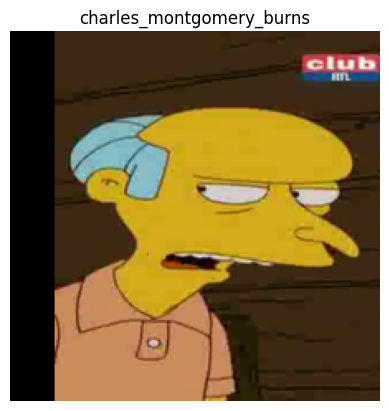

In [11]:
image, label = train_dataset[random.randint(0, len(train_dataset))]
print(image.shape)
plt.imshow(image.squeeze().permute(1, 2, 0))
plt.title(class_names[label])
plt.gca().axis('off')

torch.Size([3, 224, 224])


(-0.5, 223.5, 223.5, -0.5)

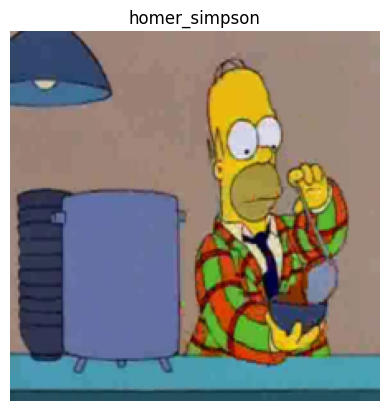

In [12]:
image, label = test_dataset[random.randint(0, len(test_dataset))]
print(image.shape)
plt.imshow(image.squeeze().permute(1, 2, 0))
plt.title(class_names[label])
plt.gca().axis('off')

In [13]:
print(f"train_dataset size: {len(train_dataset)}, \ntest_dataset size: {len(test_dataset)}")

train_dataset size: 16727, 
test_dataset size: 4381


In [14]:
train_labels = [label for _, label in train_dataset.samples]
train_counts = Counter(train_labels)
class_counts = get_class_counts(train_path)
# class_counts

In [15]:
BATCH_SIZE = 128

num_classes = len(train_counts)
class_counts = np.array([train_counts[cls] for cls in range(num_classes)])

class_weights = 1.0 / class_counts
class_weights /= class_weights.sum()
train_weights = [class_weights[label] for label in train_labels]
train_weights = torch.tensor(train_weights, dtype=torch.float).to(device)

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

In [16]:
EPOCHS = 7
model = resnet50()
model.load_state_dict(torch.load('resnet50-19c8e357.pth', weights_only=False))
model.fc = torch.nn.Linear(in_features=2048, out_features=42)

for param in model.parameters():
  param.requires_grad = False
for param in model.fc.parameters():
  param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True

model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                lr=1e-4, weight_decay=0.001)

In [17]:
def accuracy_fn(y_true, y_pred):
  y_pred = torch.argmax(y_pred, dim=1)
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [18]:
loss_values = []

In [19]:
for epoch in range(EPOCHS):
    print(f"\nEPOCH {epoch+1}")
    model.train()
    train_loss, test_loss = 0, 0
    train_acc = 0
    for i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        train_pred = model(X)
        loss = loss_fn(train_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_fn(y, train_pred)

        loss.backward()
        optimizer.step()
        if i % 100 == 0 and i != 0:
          print(f"Train loss: {(train_loss/i):.4f} ")
    train_loss /= len(train_dataloader)
    loss_values.append(train_loss)
    train_acc /= len(train_dataloader)
    print(f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}%")

    model.eval()
    accuracy = 0
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        test_pred = model(X)
        test_loss += loss_fn(test_pred, y).item()
        accuracy += accuracy_fn(y, test_pred)
    test_loss /= len(test_dataloader)
    accuracy /= len(test_dataloader)
    print(f"Test_loss: {test_loss:.4f}, Test acc: {accuracy:.4f}%")


EPOCH 1
Train loss: 1.5057 
Train loss: 1.3063, Train acc: 70.3451%
Test_loss: 0.7056, Test acc: 85.0085%

EPOCH 2
Train loss: 0.4994 
Train loss: 0.4714, Train acc: 88.5720%
Test_loss: 0.4677, Test acc: 89.3157%

EPOCH 3
Train loss: 0.3256 
Train loss: 0.3163, Train acc: 91.8517%
Test_loss: 0.3876, Test acc: 90.9321%

EPOCH 4
Train loss: 0.2430 
Train loss: 0.2339, Train acc: 94.0426%
Test_loss: 0.3198, Test acc: 92.7047%

EPOCH 5
Train loss: 0.2083 
Train loss: 0.2038, Train acc: 94.8477%
Test_loss: 0.2768, Test acc: 93.6684%

EPOCH 6
Train loss: 0.1890 
Train loss: 0.1818, Train acc: 95.4591%
Test_loss: 0.2501, Test acc: 94.4866%

EPOCH 7
Train loss: 0.1544 
Train loss: 0.1549, Train acc: 96.0948%
Test_loss: 0.2625, Test acc: 93.9509%


Text(0, 0.5, 'loss')

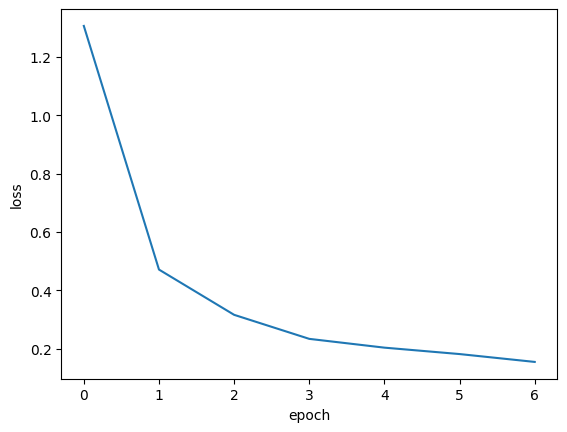

In [20]:
plt.plot(loss_values, label='train loss')
plt.xlabel('epoch')
plt.ylabel('loss')

In [21]:
torch.save(model.state_dict(), 'model_state_dict_freeezed.pth')

In [22]:
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        preds = model(X)
        preds = preds.cpu().detach()
        preds = torch.argmax(preds, dim=1)
        all_preds.extend(preds.numpy())
        all_labels.extend(y.numpy())

In [23]:
avg_f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Average F1-Score: {avg_f1}")

Average F1-Score: 0.9287033180676598
